# Preprocessing Data for Handwriting generation

## Abstract

Here we will extract the labels and the co-ordinates from the dataset which can be provided to the training module to generate a LSTM model. The data is in a xml format and is taken from the "IAM On-Line Handwriting Database". It consist of ascii text lines and its corresponding x and y co-ordinates. We extract the data by traversing through all te xml files and the tags in those files and converting them into numpy arrays. We also perform normalization of co-ordinates.

#### Loading Libraries

In [1]:
import os
import html
import pickle
import numpy as np
import xml.etree.cElementTree as ElementTree

### Process data

* Here traverse through all the XML files and then extract the x an y co-ordinates and the text corresponding to thoes co-ordinates. 
* We then normalize the co-ordinates by subtracting the mean and dividing by standard diviation

In [2]:
data = []
charset = set()
file_no = 0
path = 'data'

for root, dirs, files in os.walk(path):
    for file in files:
        file_no+=1
        file_name, extension = os.path.splitext(file)
        if extension == '.xml':
            xml = ElementTree.parse(os.path.join(root, file)).getroot()
            transcription = xml.findall('Transcription')
            if not transcription:
                continue
            texts = [html.unescape(tag.get('text')) for tag in xml.findall('Transcription')[0].findall('TextLine')]

            stroke = [s.findall('Point') for s in xml.findall('StrokeSet')[0].findall('Stroke')]
            points = [np.array([[int(p.get('x')), int(p.get('y')), 0] for p in point_tag]) for point_tag in stroke]

            strokes = []
            mid_points = []

            for point in points:
                point[-1, 2] = 1

                xmax, ymax = max(point, key=lambda x: x[0])[0], max(point, key=lambda x: x[1])[1]
                xmin, ymin = min(point, key=lambda x: x[0])[0], min(point, key=lambda x: x[1])[1]

                strokes += [point]
                mid_points += [[(xmax + xmin) / 2., (ymax + ymin) / 2.]]

            distances = [-(abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])) for p1, p2 in zip(mid_points, mid_points[1:])]
            splits = sorted(np.argsort(distances)[:len(texts) - 1] + 1)

            lines = []
            for b, e in zip([0] + splits, splits + [len(strokes)]):
                lines += [[p for pts in strokes[b:e] for p in pts]]

            charset |= set(''.join(texts))
            data += [(texts, lines)]
print("Done")

Done


Here we align the co-ordinates as strokes to the labels.

In [3]:
translation = {'<NULL>': 0}
for c in ''.join(sorted(charset)):
    translation[c] = len(translation)

dataset = []
labels = []
for texts, lines in data:
    for text, line in zip(texts, lines):
        line = np.array(line, dtype=np.float32)
        line[:, 0] = line[:, 0] - np.min(line[:, 0])
        line[:, 1] = line[:, 1] - np.min(line[:, 1])

        dataset += [line]
        labels += [list(map(lambda x: translation[x], text))]

In [4]:
whole_data = np.concatenate(dataset, axis=0)
std_y = np.std(whole_data[:, 1])
norm_data = []
for line in dataset:
    line[:, :2] /= std_y
    norm_data += [line]
dataset = norm_data

print('datset = {}; labels = {}'.format(len(dataset), len(labels)))

datset = 10867; labels = 10867


Saving the co-ordinates, lables and translation in a file.

In [5]:
try:
    os.makedirs('processed_data')
except FileExistsError:
    pass
np.save(os.path.join('processed_data', 'dataset'), np.array(dataset))
np.save(os.path.join('processed_data', 'labels'), np.array(labels))
with open(os.path.join('processed_data', 'translation.pkl'), 'wb') as file:
    pickle.dump(translation, file)

#### Verifying transformed data

we can plot the strokes using matplotlib plot function
Each stroke can be identified by the individual colors

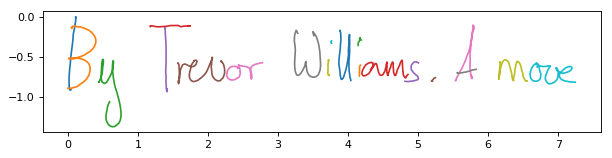

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

def split_strokes(points):
    points = np.array(points)
    strokes = []
    b = 0
    for e in range(len(points)):
        if points[e, 2] == 1.:
            strokes += [points[b: e + 1, :2].copy()]
            b = e + 1
    return strokes

def cumsum(points):
    sums = np.cumsum(points[:, :2], axis=0)
    return np.concatenate([sums, points[:, 2:]], axis=1)

figure(num=None, figsize=(9, 2), dpi=80, facecolor='w', edgecolor='k')
for stroke in split_strokes(np.array(dataset[0])):
    plt.plot(stroke[:, 0], -stroke[:, 1])
plt.show()

### Conclusion

1. The data consists of co-ordinates (x, y, end of stroke) alond with the corresponding text labels
2. The co-ordinates are normalized
3. the lable need to be one hot encoded befor providing for training. (this will be done in the training module)

## Licence

<div class="alert alert-block alert-info">
MIT License 

Copyright (c) 2019 Ninad Subhedar 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: 

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</div>